In [6]:
from datetime import date, timedelta
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import LSTM
from keras import callbacks
from keras.callbacks import ModelCheckpoint

In [7]:
import pandas as pd
       
dtypes = {'store_nbr': np.dtype('int64'),
          'item_nbr': np.dtype('int64'),
          'unit_sales': np.dtype('float64'),
          'onpromotion': np.dtype('O')}

train = pd.read_csv('C:/Users/smr99353/Desktop/Asma_Ryerson/MRP/favorita-grocery-sales-forecasting/input/trainCombine/combined_csv.csv', dtype=dtypes)
test = pd.read_csv('C:/Users/smr99353/Desktop/Asma_Ryerson/MRP/favorita-grocery-sales-forecasting/input/test.csv', dtype=dtypes)
stores = pd.read_csv('C:/Users/smr99353/Desktop/Asma_Ryerson/MRP/favorita-grocery-sales-forecasting/input/stores.csv')
items = pd.read_csv('C:/Users/smr99353/Desktop/Asma_Ryerson/MRP/favorita-grocery-sales-forecasting/input/items.csv')
trans = pd.read_csv('C:/Users/smr99353/Desktop/Asma_Ryerson/MRP/favorita-grocery-sales-forecasting/input/transactions.csv')
oil = pd.read_csv('C:/Users/smr99353/Desktop/Asma_Ryerson/MRP/favorita-grocery-sales-forecasting/input/oil.csv') 
holidays = pd.read_csv('C:/Users/smr99353/Desktop/Asma_Ryerson/MRP/favorita-grocery-sales-forecasting/input/holidays_events.csv')

In [9]:
print('Shape : ', train.shape)

Shape :  (23808261, 6)


In [10]:
print('Shape : ', test.shape)
test.head(10)

Shape :  (3370464, 5)


,id,date,store_nbr,item_nbr,onpromotion
0,125497040,2017-08-16,1,96995,False
1,125497041,2017-08-16,1,99197,False
2,125497042,2017-08-16,1,103501,False
3,125497043,2017-08-16,1,103520,False
4,125497044,2017-08-16,1,103665,False
5,125497045,2017-08-16,1,105574,False
6,125497046,2017-08-16,1,105575,False
7,125497047,2017-08-16,1,105576,False
8,125497048,2017-08-16,1,105577,False
9,125497049,2017-08-16,1,105693,False


In [13]:
df_test = test

In [14]:
train['date'] = train['date'].astype('datetime64[ns]')
dtrain['date'].head()

0   2017-01-01
1   2017-01-01
2   2017-01-01
3   2017-01-01
4   2017-01-01
Name: date, dtype: datetime64[ns]

In [15]:
data2017Com = train.loc[train.date>=pd.datetime(2017,1,1)]

In [16]:
data2017train = data2017Com.set_index(
    ["store_nbr", "item_nbr", "date"])[["onpromotion"]].unstack(
        level=-1).fillna(False)
data2017train.columns = data2017train.columns.get_level_values(1)
data2017test = df_test[["onpromotion"]].unstack(level=-1).fillna(False)
data2017test = data2017test.reindex(data2017train.index).fillna(False)
data2017 = pd.concat([data2017train, data2017test], axis=1)
del data2017test, data2017train

In [19]:
data2017Com = data2017Com.set_index(
    ["store_nbr", "item_nbr", "date"])[["unit_sales"]].unstack(
        level=-1).fillna(0)
data2017Com.columns = data2017Com.columns.get_level_values(1)
items = items.reindex(data2017Com.index.get_level_values(1))

In [1]:
def get_timespan(df, dt, minus, periods, freq='D'):
    return df[pd.date_range(dt - timedelta(days=minus), periods=periods, freq=freq)]

def prepare_dataset(com_2017, istrain=True):
    X = pd.DataFrame({
        "day_1_2017": get_timespan(data2017Com, com_2017, 1, 1).values.ravel(),
        "mean_3_2017": get_timespan(data2017Com, com_2017, 3, 3).mean(axis=1).values,
        "mean_7_2017": get_timespan(data2017Com, com_2017, 7, 7).mean(axis=1).values
    })
    if istrain:
        y = data2017Com[
            pd.date_range(com_2017, periods=16)
        ].values
        return X, y
    return X

In [21]:
com_2017 = date(2017, 7, 1)
X_l, y_l = [], []
for i in range(1):
    delta = timedelta(days=7 * i)
    X_tmp, y_tmp = prepare_dataset(
        com_2017 + delta
    )
    X_l.append(X_tmp)
    y_l.append(y_tmp)

In [22]:
X_train = pd.concat(X_l, axis=0)
y_train = np.concatenate(y_l, axis=0)

In [23]:
X_val, y_val = prepare_dataset(date(2017, 7, 1))
X_test = prepare_dataset(date(2017, 8, 16), istrain=False)

stores_items = pd.DataFrame(index=data2017Com.index)
test_ids = df_test[['id']]

items = items.reindex( stores_items.index.get_level_values(1) )

In [24]:
X_train.sample(10)

,day_1_2017,mean_3_2017,mean_7_2017
153334,0.0,4.000000,2.285714
131020,0.0,0.000000,0.000000
115184,2.0,1.333333,2.428571
143056,22.0,28.666667,30.142857
143477,5.0,4.666667,2.428571
133442,1.0,0.666667,0.571429
110625,2.0,1.333333,1.428571
18813,0.0,0.666667,0.857143
105558,1.0,1.333333,0.571429
25922,5.0,4.000000,4.142857


In [25]:
X_train = X_train.as_matrix()
X_test = X_test.as_matrix()
X_val = X_val.as_matrix()
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))

In [26]:
from keras import backend
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

## LSTM

In [32]:
model = Sequential()
model.add(LSTM(32, input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(Dropout(.1))
model.add(Dense(32))
model.add(Dropout(.2))
model.add(Dense(1))
model.compile(loss = 'mse', optimizer='adam', metrics=[rmse,'mse'])

N_EPOCHS = 5
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 32)                4608      
_________________________________________________________________
dropout_13 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_14 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 33        
Total params: 5,697
Trainable params: 5,697
Non-trainable params: 0
_________________________________________________________________


In [33]:
N_EPOCHS = 5

val_pred = []
test_pred = []


# wtpath = 'weights.hdf5'  # To save best epoch. But need Keras bug to be fixed first.
sample_weights=np.array( pd.concat([items["perishable"]] * 6) * 0.25 + 1 )
for i in range(16):
    print("=" * 50)
    print("Step %d" % (i+1))
    print("=" * 50)
    y = y_train[:, i]
    xv = X_val
    yv = y_val[:, i]
    model.fit(X_train, y, batch_size = 512, epochs = N_EPOCHS, verbose=2 , validation_data=(xv,yv) ) 
    val_pred.append(model.predict(X_val))
    test_pred.append(model.predict(X_test))
      

Step 1
Train on 167515 samples, validate on 167515 samples
Epoch 1/5
 - 3s - loss: 318.3915 - rmse: 4.4731 - mean_squared_error: 318.3915 - val_loss: 246.6257 - val_rmse: 3.6289 - val_mean_squared_error: 246.6257
Epoch 2/5
 - 2s - loss: 229.8655 - rmse: 3.6744 - mean_squared_error: 229.8655 - val_loss: 210.4885 - val_rmse: 3.5388 - val_mean_squared_error: 210.4885
Epoch 3/5
 - 2s - loss: 212.6588 - rmse: 3.7232 - mean_squared_error: 212.6588 - val_loss: 204.8268 - val_rmse: 3.4308 - val_mean_squared_error: 204.8268
Epoch 4/5
 - 2s - loss: 205.2910 - rmse: 3.7674 - mean_squared_error: 205.2910 - val_loss: 192.2461 - val_rmse: 3.4668 - val_mean_squared_error: 192.2461
Epoch 5/5
 - 2s - loss: 201.7335 - rmse: 3.8056 - mean_squared_error: 201.7335 - val_loss: 191.6744 - val_rmse: 3.3816 - val_mean_squared_error: 191.6744
Step 2
Train on 167515 samples, validate on 167515 samples
Epoch 1/5
 - 2s - loss: 203.7323 - rmse: 4.1874 - mean_squared_error: 203.7323 - val_loss: 194.1133 - val_rmse: 

Step 10
Train on 167515 samples, validate on 167515 samples
Epoch 1/5
 - 2s - loss: 322.3388 - rmse: 3.2723 - mean_squared_error: 322.3388 - val_loss: 310.8412 - val_rmse: 2.9149 - val_mean_squared_error: 310.8412
Epoch 2/5
 - 2s - loss: 317.1612 - rmse: 3.2631 - mean_squared_error: 317.1612 - val_loss: 309.4658 - val_rmse: 2.9144 - val_mean_squared_error: 309.4658
Epoch 3/5
 - 2s - loss: 324.7276 - rmse: 3.2335 - mean_squared_error: 324.7276 - val_loss: 308.1897 - val_rmse: 2.9267 - val_mean_squared_error: 308.1897
Epoch 4/5
 - 2s - loss: 313.5064 - rmse: 3.2303 - mean_squared_error: 313.5064 - val_loss: 308.3404 - val_rmse: 2.8636 - val_mean_squared_error: 308.3404
Epoch 5/5
 - 2s - loss: 321.8588 - rmse: 3.2471 - mean_squared_error: 321.8588 - val_loss: 320.1710 - val_rmse: 2.8677 - val_mean_squared_error: 320.1710
Step 11
Train on 167515 samples, validate on 167515 samples
Epoch 1/5
 - 2s - loss: 264.3344 - rmse: 3.1507 - mean_squared_error: 264.3344 - val_loss: 258.8647 - val_rmse

In [34]:
n_public = 5 # Number of days in public test set
weights=pd.concat([items["perishable"]]) * 0.25 + 1
print("Unweighted validation mse: ", mean_squared_error(
    y_val, np.array(val_pred).squeeze(axis=2).transpose()) )
print("Full validation mse:       ", mean_squared_error(
    y_val, np.array(val_pred).squeeze(axis=2).transpose(), sample_weight=weights) )
print("'Public' validation mse:   ", mean_squared_error(
    y_val[:,:n_public], np.array(val_pred).squeeze(axis=2).transpose()[:,:n_public], 
    sample_weight=weights) )
print("'Private' validation mse:  ", mean_squared_error(
    y_val[:,n_public:], np.array(val_pred).squeeze(axis=2).transpose()[:,n_public:], 
    sample_weight=weights) )

Unweighted validation mse:  269.8975140632682
Full validation mse:        nan
'Public' validation mse:    nan
'Private' validation mse:   nan


In [35]:
y_test = np.array(test_pred).squeeze(axis=2).transpose()
df_preds = pd.DataFrame(
    y_test, index=stores_items.index,
    columns=pd.date_range("2017-08-16", periods=16)
).stack().to_frame("unit_sales")
df_preds.index.set_names(["store_nbr", "item_nbr", "date"], inplace=True)


In [36]:
submission = test_ids.join(df_preds["unit_sales"], how="left").fillna(0)
submission["unit_sales"] = np.clip(np.expm1(submission["unit_sales"]), 0, 1000)
submission.to_csv('lstm.csv', float_format='%.4f', index=None)

ValueError: cannot join with no level specified and no overlapping names

## CNN

In [41]:
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

In [42]:
X=X_train

In [43]:
X_test1=X_test
X_val1=X_val

In [44]:
X = X.reshape((X.shape[0], X.shape[2],1 ))
X_test1 = X_test1.reshape((X_test1.shape[0], X_test1.shape[2], 1))
X_val1 = X_val1.reshape((X_val1.shape[0], X_val1.shape[2], 1))

In [45]:
#create model
model1 = Sequential()
#add model layers
model1.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(X.shape[1],X.shape[2])))
model1.add(MaxPooling1D(pool_size=1))
model1.add(Flatten())
model1.add(Dense(50, activation='relu'))
model1.add(Dense(1))

In [46]:
model1.compile(loss = 'mse', optimizer='adam', metrics=['accuracy','mse','mae',rmse])
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 1, 64)             256       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1, 64)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 50)                3250      
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 51        
Total params: 3,557
Trainable params: 3,557
Non-trainable params: 0
_________________________________________________________________


In [47]:
y = y_train[:, 1]
N_EPOCHS=5

In [48]:
xv = X_val1
yv = y_val[:, 1]
model1.fit(X, y,batch_size = 512, epochs = N_EPOCHS, verbose=2 , validation_data=(xv, yv))

Train on 167515 samples, validate on 167515 samples
Epoch 1/5
 - 2s - loss: 288.0188 - acc: 0.1413 - mean_squared_error: 288.0188 - mean_absolute_error: 4.4989 - rmse: 4.4989 - val_loss: 234.1692 - val_acc: 0.2509 - val_mean_squared_error: 234.1692 - val_mean_absolute_error: 3.9807 - val_rmse: 3.9807
Epoch 2/5
 - 1s - loss: 262.9642 - acc: 0.1643 - mean_squared_error: 262.9642 - mean_absolute_error: 4.1151 - rmse: 4.1151 - val_loss: 228.1494 - val_acc: 0.0689 - val_mean_squared_error: 228.1494 - val_mean_absolute_error: 4.6039 - val_rmse: 4.6039
Epoch 3/5
 - 1s - loss: 248.6807 - acc: 0.1364 - mean_squared_error: 248.6807 - mean_absolute_error: 4.2613 - rmse: 4.2613 - val_loss: 217.0044 - val_acc: 0.0864 - val_mean_squared_error: 217.0044 - val_mean_absolute_error: 4.2685 - val_rmse: 4.2685
Epoch 4/5
 - 1s - loss: 228.9718 - acc: 0.1748 - mean_squared_error: 228.9718 - mean_absolute_error: 4.1473 - rmse: 4.1473 - val_loss: 213.9961 - val_acc: 0.1059 - val_mean_squared_error: 213.9961 -

In [49]:
# Score trained model.
scores11 = model1.evaluate(xv11, yv11, verbose=1)
print('Test loss:', scores11[0])
print('Test accuracy:', scores11[1])

NameError: name 'xv11' is not defined

In [50]:
yhat = model1.predict(X_test1, verbose=0)
print(yhat)
print('First prediction:', yhat[0])

[[ 1.5083506]
 [ 1.6743643]
 [ 2.3245206]
 ...
 [ 1.5834916]
 [32.809406 ]
 [ 3.0301013]]
First prediction: [1.5083506]


##  Neural Networks(NN)

In [51]:
X=X_train

In [52]:
X_test1=X_test
X_val1=X_val

In [53]:
X = X.reshape((X.shape[0], X.shape[2] ))
X_test1 = X_test1.reshape((X_test1.shape[0], X_test1.shape[2]))
X_val1 = X_val1.reshape((X_val1.shape[0], X_val1.shape[2]))

In [54]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation

# Building the model
model3 = Sequential()
model3.add(Dense(64, activation='relu', input_shape=(X.shape[1],)))
model3.add(Dropout(.2))
model3.add(Dense(16, activation='relu'))
model3.add(Dropout(.1))
model3.add(Dense(1))

# Compiling the model
model3.compile(loss = 'mse', optimizer='adam', metrics=[rmse,'mse']) #mse: mean_square_error
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 64)                256       
_________________________________________________________________
dropout_15 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 16)                1040      
_________________________________________________________________
dropout_16 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 17        
Total params: 1,313
Trainable params: 1,313
Non-trainable params: 0
_________________________________________________________________


In [55]:
features = np.array(X_train)
y = y_train[:, 1]
xv = X_val1
yv = y_val[:, 1]
targets = np.array(y.reshape(y.shape[0],1))
features_validation= np.array(xv)
targets_validation = np.array(yv.reshape(yv.shape[0],1))

#print(features[:10])
#print(targets[:10])

In [58]:
epochs_tot = 100
epochs_step = 25
epochs_ratio = int(epochs_tot / epochs_step)
hist =np.array([])

for i in range(epochs_ratio):
    history = model3.fit(X, y, epochs=epochs_step, verbose=2, batch_size=100)
    print(history)    
          
    # Evaluating the model on the training and testing set
    print("Step : " , i * epochs_step, "/", epochs_tot)
    score = model3.evaluate(X, y)
    print("Training MSE:", score[1])
    score = model3.evaluate(features_validation, targets_validation)
    print("Validation MSE:", score[1], "\n")
    hist = np.concatenate((hist, np.array(history.history['mean_squared_error'])), axis = 0)

Epoch 1/25
 - 2s - loss: 170.0537 - rmse: 4.1866 - mean_squared_error: 170.0537
Epoch 2/25
 - 2s - loss: 170.5734 - rmse: 4.1839 - mean_squared_error: 170.5734
Epoch 3/25
 - 2s - loss: 169.5329 - rmse: 4.1662 - mean_squared_error: 169.5329
Epoch 4/25
 - 2s - loss: 161.1689 - rmse: 4.1470 - mean_squared_error: 161.1689
Epoch 5/25
 - 2s - loss: 164.9342 - rmse: 4.1990 - mean_squared_error: 164.9342
Epoch 6/25
 - 2s - loss: 178.7195 - rmse: 4.1556 - mean_squared_error: 178.7195
Epoch 7/25
 - 2s - loss: 189.5401 - rmse: 4.1909 - mean_squared_error: 189.5401
Epoch 8/25
 - 2s - loss: 174.6895 - rmse: 4.1847 - mean_squared_error: 174.6895
Epoch 9/25
 - 2s - loss: 167.8292 - rmse: 4.1540 - mean_squared_error: 167.8292
Epoch 10/25
 - 2s - loss: 167.0400 - rmse: 4.1825 - mean_squared_error: 167.0400
Epoch 11/25
 - 2s - loss: 170.3375 - rmse: 4.1916 - mean_squared_error: 170.3375
Epoch 12/25
 - 2s - loss: 181.0977 - rmse: 4.1789 - mean_squared_error: 181.0977
Epoch 13/25
 - 2s - loss: 167.1222 - 

Epoch 18/25
 - 3s - loss: 216.3503 - rmse: 4.1290 - mean_squared_error: 216.3503
Epoch 19/25
 - 3s - loss: 177.9663 - rmse: 4.1200 - mean_squared_error: 177.9663
Epoch 20/25
 - 2s - loss: 165.6352 - rmse: 4.0954 - mean_squared_error: 165.6352
Epoch 21/25
 - 2s - loss: 154.8153 - rmse: 4.0796 - mean_squared_error: 154.8153
Epoch 22/25
 - 3s - loss: 202.9507 - rmse: 4.1517 - mean_squared_error: 202.9507
Epoch 23/25
 - 2s - loss: 170.2731 - rmse: 4.1236 - mean_squared_error: 170.2731
Epoch 24/25
 - 2s - loss: 155.4817 - rmse: 4.1015 - mean_squared_error: 155.4817
Epoch 25/25
 - 3s - loss: 167.6919 - rmse: 4.1173 - mean_squared_error: 167.6919
Step :  75 / 100
167515/167515 [==============================] - 3s 18us/step
Training MSE: 3.807071408447506
167515/167515 [==============================] - 3s 17us/step
Validation MSE: 3.807071408447506 



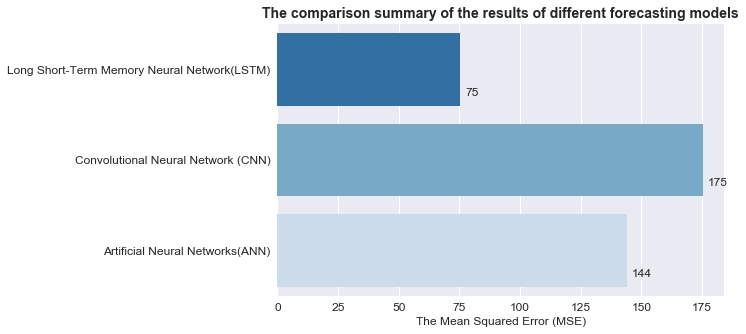

In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from pandas.tools.plotting import parallel_coordinates
from sklearn import datasets
matplotlib.style.use('ggplot')
%matplotlib inline


pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', None)

#create dataset
df =pd.DataFrame({'TEDTalk':['Artificial Neural Networks(ANN)','Convolutional Neural Network (CNN)', 'Long Short-Term Memory Neural Network(LSTM)'],'value': [144.02,175.20,75.22]})

sns.set(rc = {'figure.figsize':(8,5),'axes.labelsize': 12})
ax = sns.barplot(x="value", y="TEDTalk", data=df,  palette="Blues")
ax.set(xlabel='The Mean Squared Error (MSE)', ylabel='')
ax.set_title("The comparison summary of the results of different forecasting models",fontsize =14, fontweight='bold')
plt.tick_params(axis='both', which='major', labelsize=12)

ax.set_xticklabels(['{:0.0f}'.format(x) for x in (ax.get_xticks())])
ax.invert_yaxis()

#create loop to add percentage on bar
for p in ax.patches:
    ax.annotate('{:0.0f}'.format(p.get_width()), (p.get_x() + p.get_width(), p.get_y()), xytext=(5, 10), textcoords='offset points')
plt.show()

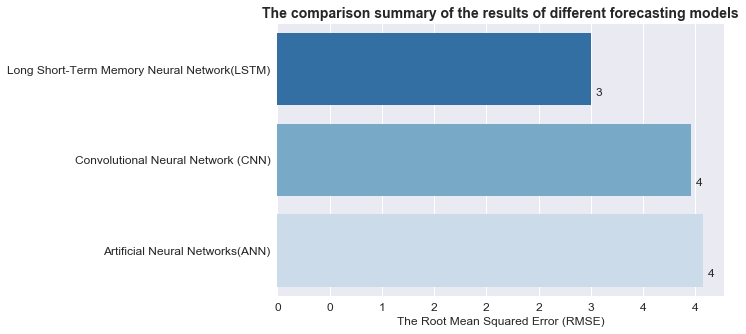

In [30]:
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', None)

#create dataset
df =pd.DataFrame({'TEDTalk':['Artificial Neural Networks(ANN)','Convolutional Neural Network (CNN)', 'Long Short-Term Memory Neural Network(LSTM)'],'value': [4.07,3.96,3]})

sns.set(rc = {'figure.figsize':(8,5),'axes.labelsize': 12})
ax = sns.barplot(x="value", y="TEDTalk", data=df,  palette="Blues")
ax.set(xlabel='The Root Mean Squared Error (RMSE)', ylabel='')
ax.set_title("The comparison summary of the results of different forecasting models",fontsize =14, fontweight='bold')
plt.tick_params(axis='both', which='major', labelsize=12)

ax.set_xticklabels(['{:0.0f}'.format(x) for x in (ax.get_xticks())])
ax.invert_yaxis()

#create loop to add percentage on bar
for p in ax.patches:
    ax.annotate('{:0.0f}'.format(p.get_width()), (p.get_x() + p.get_width(), p.get_y()), xytext=(5, 10), textcoords='offset points')
plt.show()